# A 1D convolutional net in Keras
Very little preprocessing was needed. Batch normalization made a huge difference, and made it possible to achieve perfect classification within the Kaggle kernel.

In [1]:
#We import libraries for linear algebra, graphs, and evaluation of results
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.ndimage.filters import uniform_filter1d

In [2]:
#Keras is a high level neural networks library, based on either tensorflow or theano
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam

Using TensorFlow backend.


## Load the data

As the data format is so simple, we do not need pandas.

In [3]:
#INPUT_LIB = '../input/'
INPUT_LIB = './'
raw_data = np.loadtxt(INPUT_LIB + 'exoTrain.csv', skiprows=1, delimiter=',')
x_train = raw_data[:, 1:]
y_train = raw_data[:, 0, np.newaxis] - 1.
raw_data = np.loadtxt(INPUT_LIB + 'exoTest.csv', skiprows=1, delimiter=',')
x_test = raw_data[:, 1:]
y_test = raw_data[:, 0, np.newaxis] - 1.
del raw_data

Scale each observation to zero mean and unit variance.

In [4]:
x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / 
           np.std(x_train, axis=1).reshape(-1,1))
x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / 
          np.std(x_test, axis=1).reshape(-1,1))

This is our only preprocessing step: We add an input corresponding to the running average over
200 time steps. This helps the net ignore high frequency noise and instead look at non-local
information. Look at the graphs below to see what it does.

In [5]:
x_train = np.stack([x_train, uniform_filter1d(x_train, axis=1, size=200)], axis=2)
x_test = np.stack([x_test, uniform_filter1d(x_test, axis=1, size=200)], axis=2)

## Train the model

With the Sequential API for Keras, we only need to add the layers one at a time. Each 1D convolutional layers corresponds to a local filter, and then a pooling layer reduces the data length by approximately a factor 4. At the end, there are two dense layers, just as we would in a typical image classifier. Batch normalization layers speed up convergence. 

In [6]:
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=11, activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


The data here is extremely unbalanced, with only a few positive examples. To correct for this, I use the positive examples a lot more often, so that the net sees 50% of each over each bats. Also, I generate new examples by rotation them randomly in time. This is called augmentation and is similar to when we rotate/shift examples in image classification.

In [7]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

The hyperparameters here are chosen to finish training within the Kernel, rather than to get optimal results. On a GPU, I might have chosen a smaller learning rate, and perhaps SGD instead of Adam. As it turned out, results were brilliant anyway.

In [8]:
#Start with a slightly lower learning rate, to ensure convergence
model.compile(optimizer=Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=0, epochs=5,
                           steps_per_epoch=x_train.shape[1]//32)

Instructions for updating:
Use tf.cast instead.


In [9]:
#Then speed things up a little
model.compile(optimizer=Adam(4e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(batch_generator(x_train, y_train, 32), 
                           validation_data=(x_test, y_test), 
                           verbose=2, epochs=40,
                           steps_per_epoch=x_train.shape[1]//32)

Epoch 1/40
 - 2s - loss: 0.7080 - acc: 0.5641 - val_loss: 0.5584 - val_acc: 0.7702
Epoch 2/40
 - 1s - loss: 0.6713 - acc: 0.6152 - val_loss: 0.5603 - val_acc: 0.7737
Epoch 3/40
 - 1s - loss: 0.6476 - acc: 0.6379 - val_loss: 0.5710 - val_acc: 0.7649
Epoch 4/40
 - 1s - loss: 0.6292 - acc: 0.6493 - val_loss: 0.5619 - val_acc: 0.7789
Epoch 5/40
 - 1s - loss: 0.6248 - acc: 0.6537 - val_loss: 0.5379 - val_acc: 0.8123
Epoch 6/40
 - 1s - loss: 0.6204 - acc: 0.6667 - val_loss: 0.5367 - val_acc: 0.8175
Epoch 7/40
 - 1s - loss: 0.6178 - acc: 0.6616 - val_loss: 0.5392 - val_acc: 0.8175
Epoch 8/40
 - 1s - loss: 0.6073 - acc: 0.6739 - val_loss: 0.5325 - val_acc: 0.8175
Epoch 9/40
 - 1s - loss: 0.5909 - acc: 0.6903 - val_loss: 0.5383 - val_acc: 0.8175
Epoch 10/40
 - 1s - loss: 0.5996 - acc: 0.6853 - val_loss: 0.5206 - val_acc: 0.8281
Epoch 11/40
 - 1s - loss: 0.5847 - acc: 0.6847 - val_loss: 0.5277 - val_acc: 0.8246
Epoch 12/40
 - 1s - loss: 0.5897 - acc: 0.6907 - val_loss: 0.5248 - val_acc: 0.8316
E

#Evaluate the model

First we look at convergence

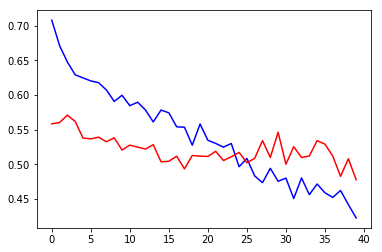

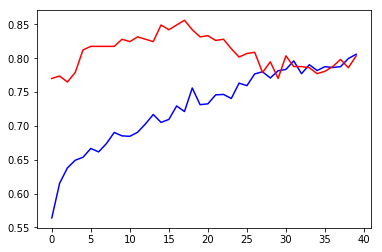

In [11]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

We then use our trained net to classify the test set.

In [12]:
non_idx = np.where(y_test[:,0] == 0.)[0]
yes_idx = np.where(y_test[:,0] == 1.)[0]
y_hat = model.predict(x_test)[:,0]

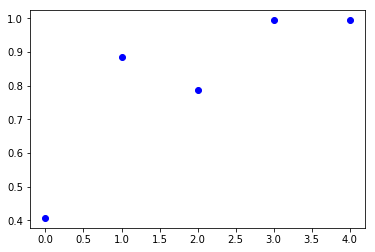

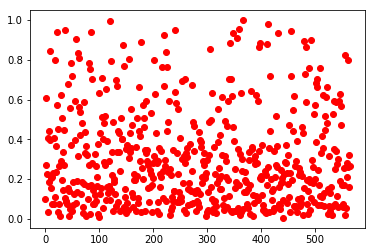

In [13]:
plt.plot([y_hat[i] for i in yes_idx], 'bo')
plt.show()
plt.plot([y_hat[i] for i in non_idx], 'ro')
plt.show()

These graphs show that the five positive examples all get 0.95-1.00 score. Also, almost all negative examples get score close to zero, except a few in the 0.9-1.0 range. This is encouraging.

We now choose an optimal cutoff score for classification. Sklearn can help us with this.

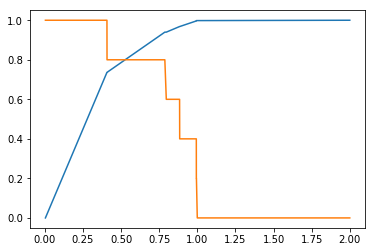

Crossover at 0.41 with specificity 0.74


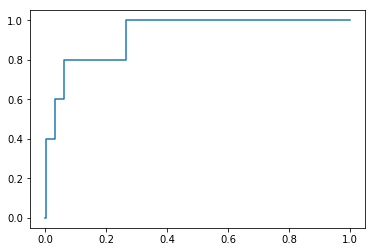

ROC area under curve is 0.93


In [14]:
y_true = (y_test[:, 0] + 0.5).astype("int")
fpr, tpr, thresholds = roc_curve(y_true, y_hat)
plt.plot(thresholds, 1.-fpr)
plt.plot(thresholds, tpr)
plt.show()
crossover_index = np.min(np.where(1.-fpr <= tpr))
crossover_cutoff = thresholds[crossover_index]
crossover_specificity = 1.-fpr[crossover_index]
print("Crossover at {0:.2f} with specificity {1:.2f}".format(crossover_cutoff, crossover_specificity))
plt.plot(fpr, tpr)
plt.show()
print("ROC area under curve is {0:.2f}".format(roc_auc_score(y_true, y_hat)))

Let's take a look at the misclassified data (if any):

7


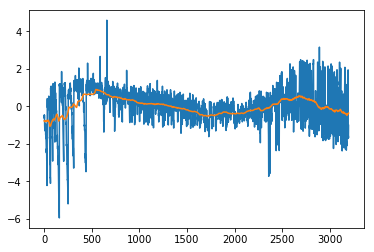

11


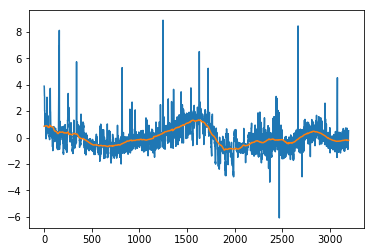

13


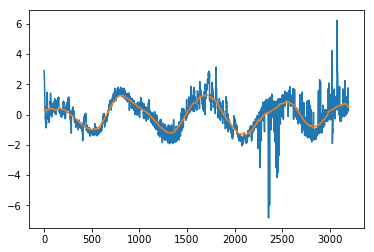

23


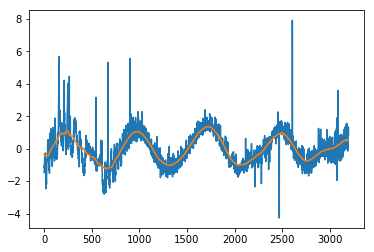

26


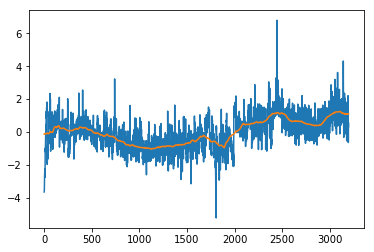

27


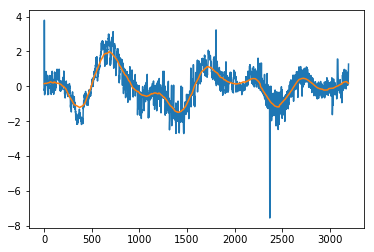

28


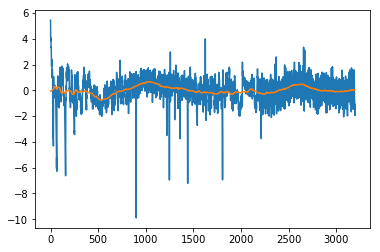

34


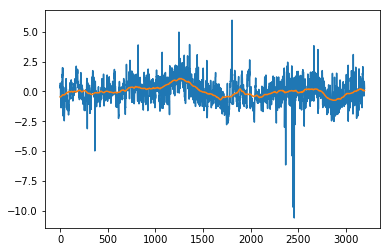

35


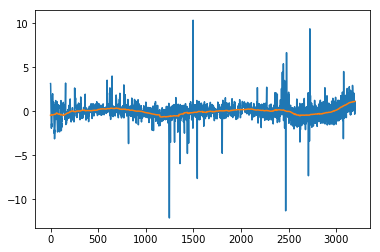

40


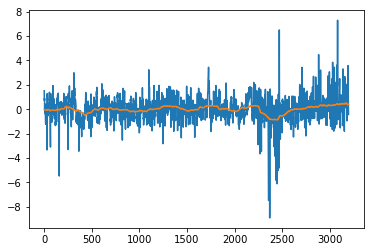

42


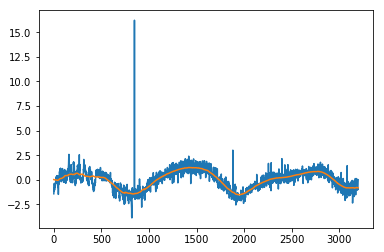

46


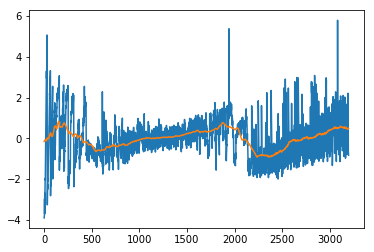

51


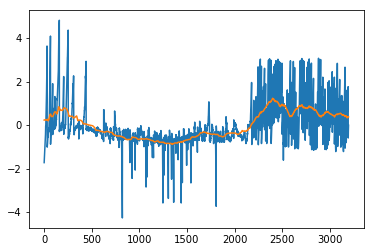

53


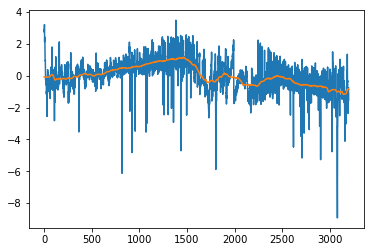

54


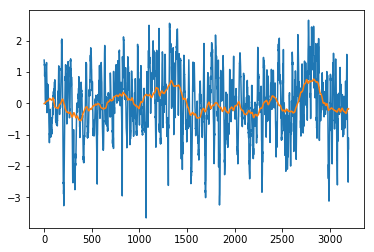

59


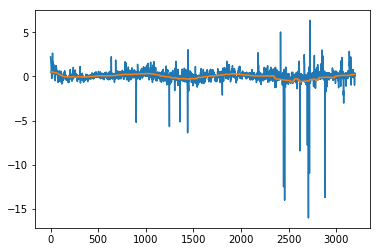

61


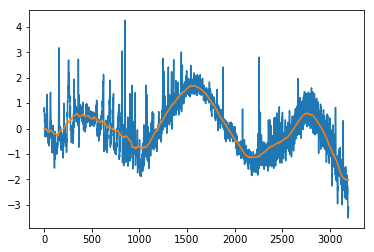

65


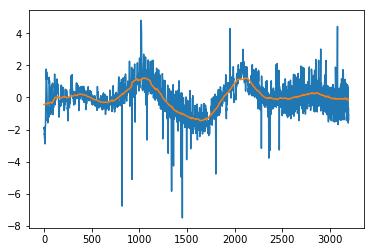

67


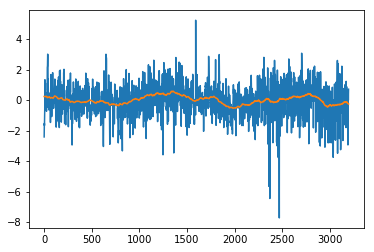

68


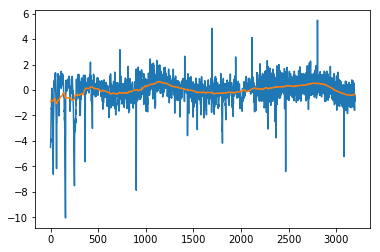

69


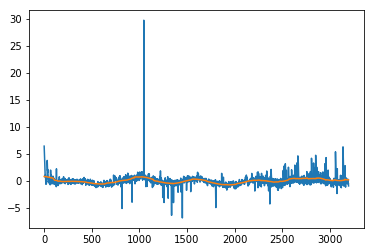

70


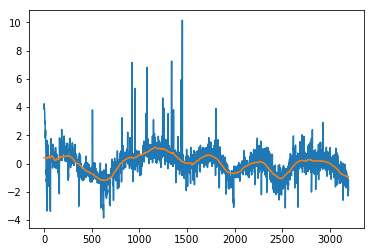

72


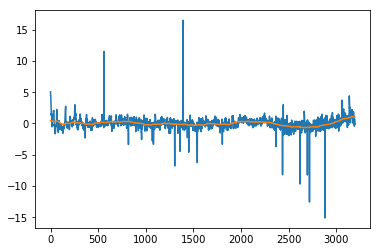

77


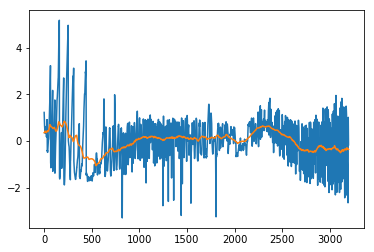

79


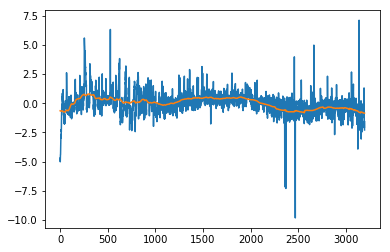

85


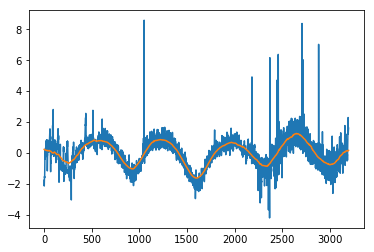

87


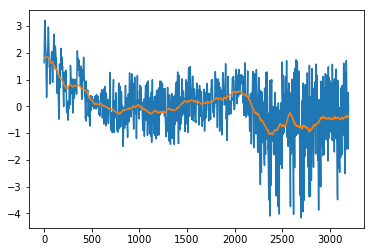

89


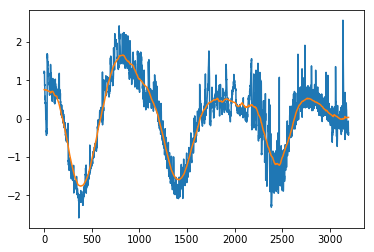

91


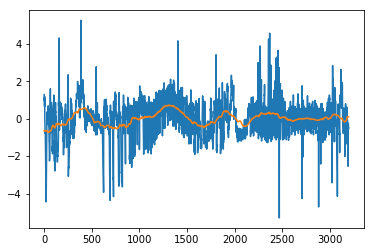

104


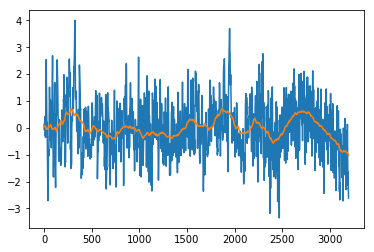

106


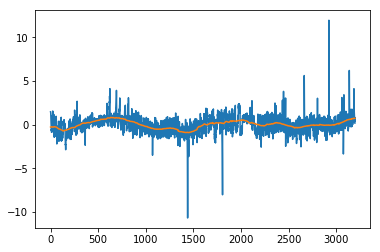

109


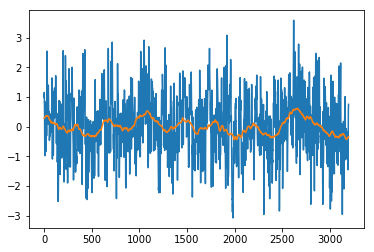

110


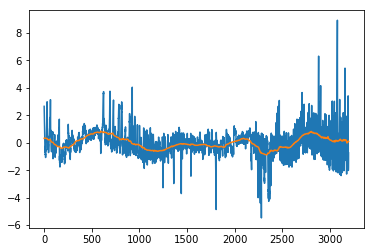

114


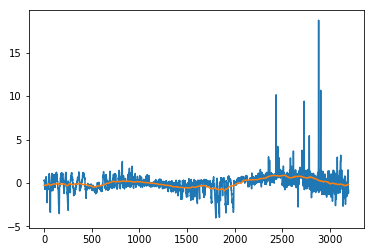

116


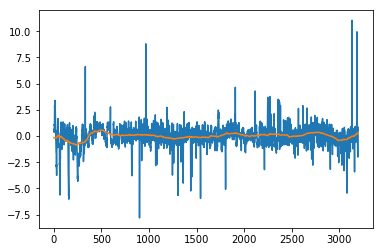

117


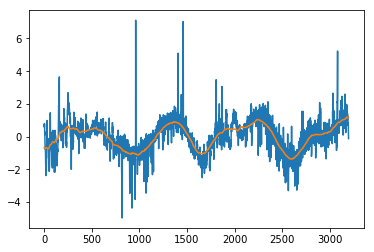

124


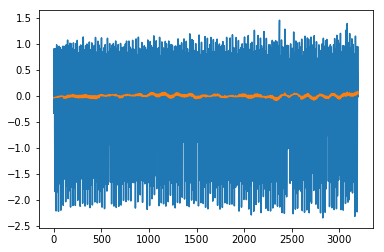

127


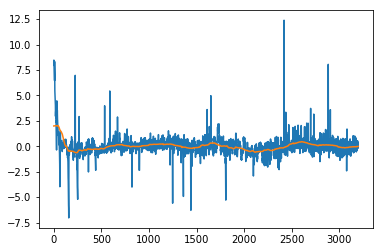

130


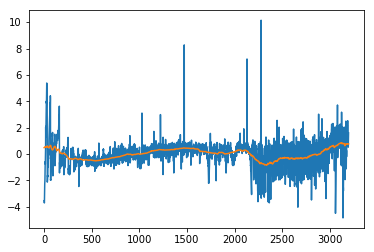

136


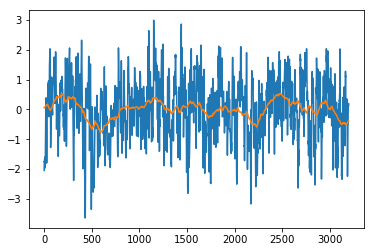

137


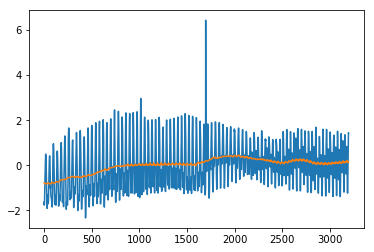

139


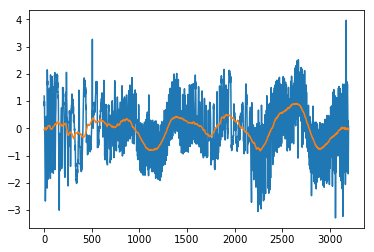

141


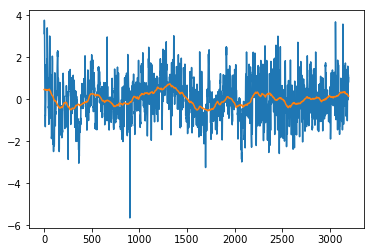

145


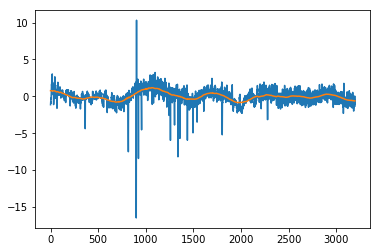

148


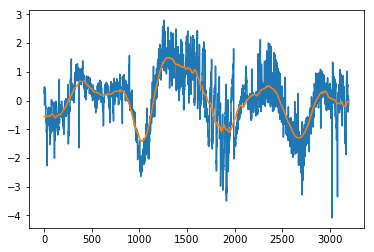

150


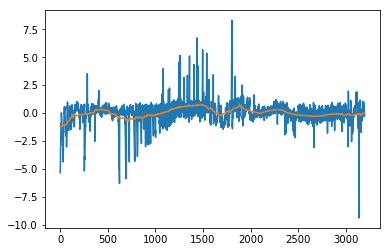

159


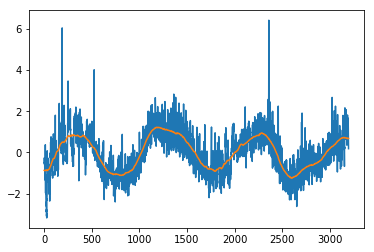

162


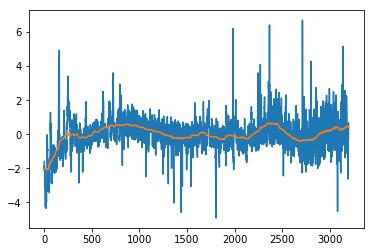

164


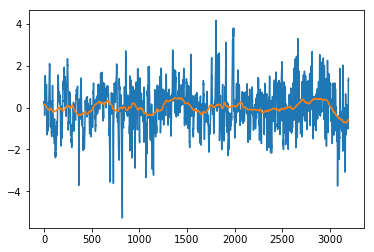

165


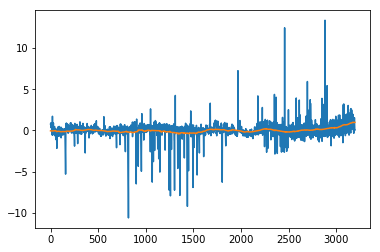

175


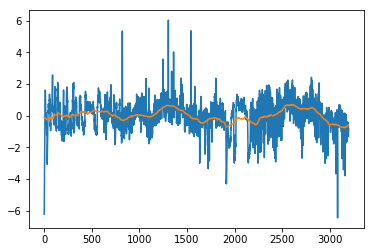

178


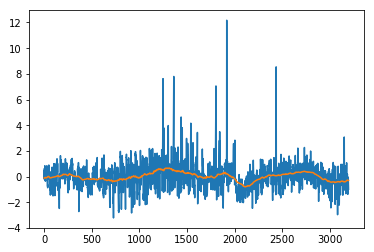

179


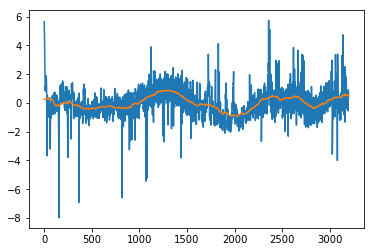

181


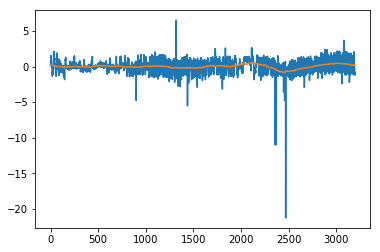

183


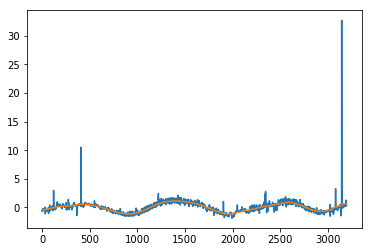

185


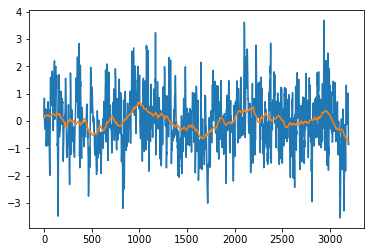

187


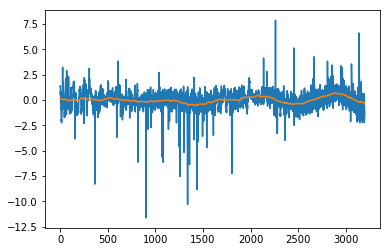

188


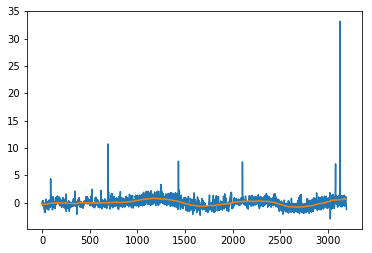

192


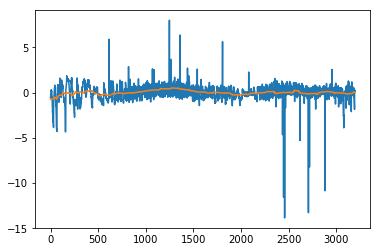

201


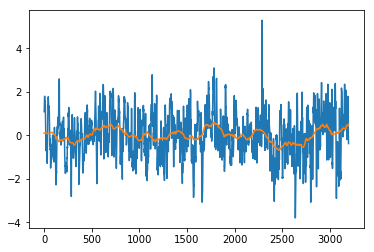

206


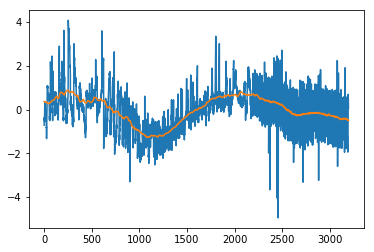

208


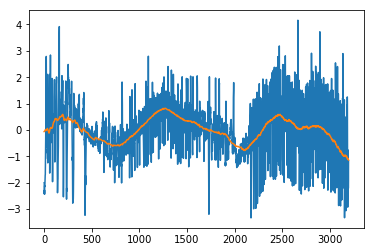

209


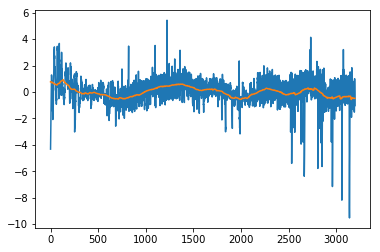

221


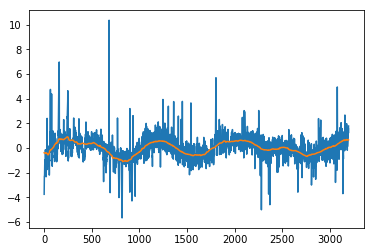

224


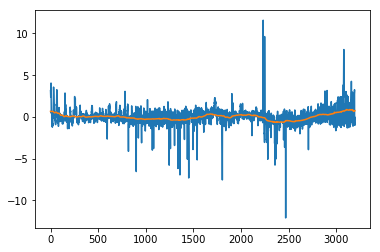

225


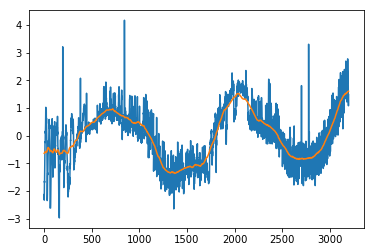

229


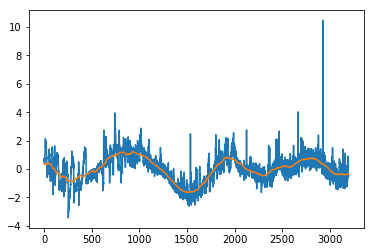

230


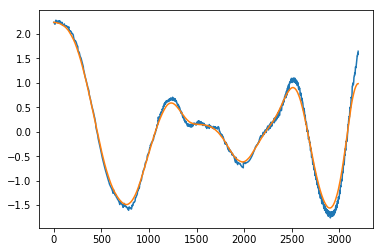

231


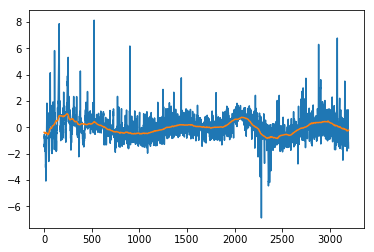

233


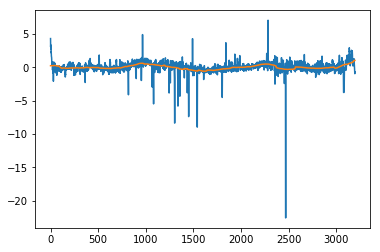

234


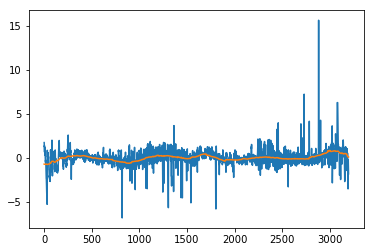

245


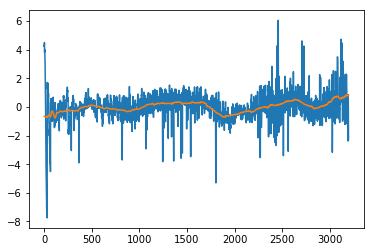

246


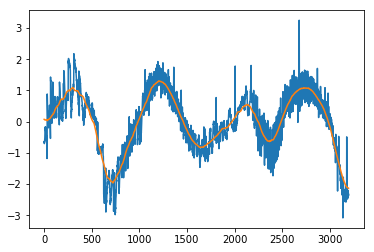

247


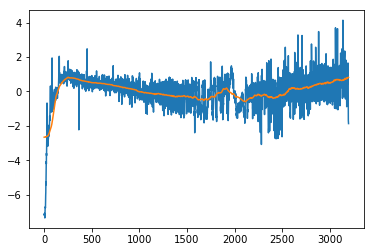

251


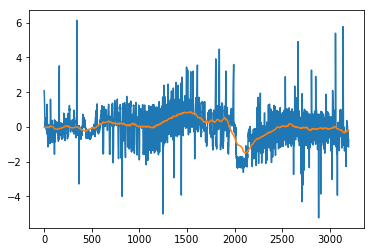

258


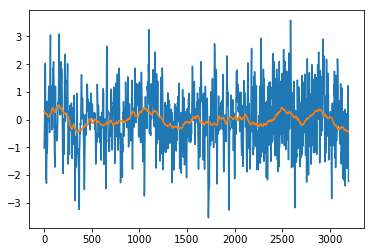

263


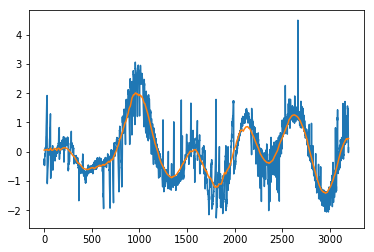

276


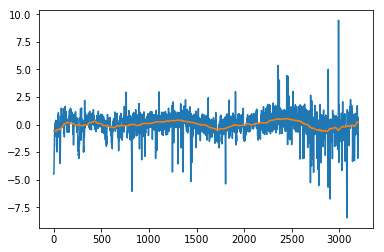

278


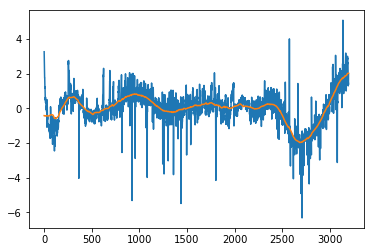

280


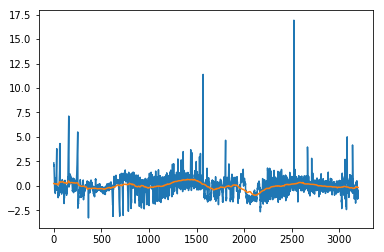

289


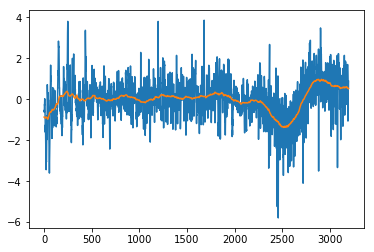

308


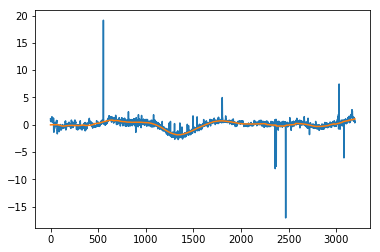

310


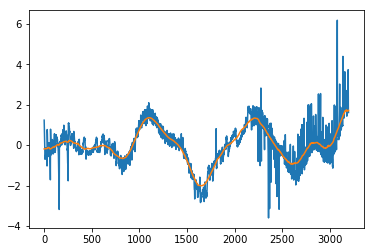

312


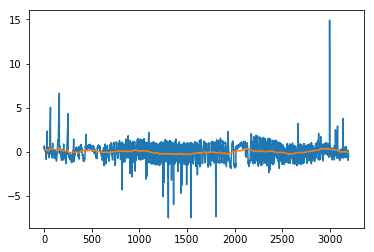

313


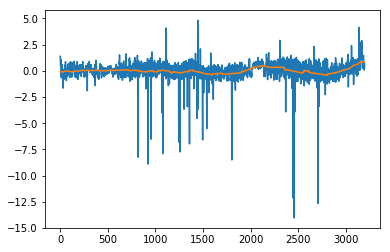

325


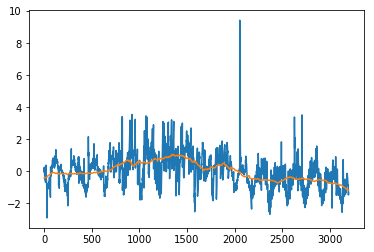

329


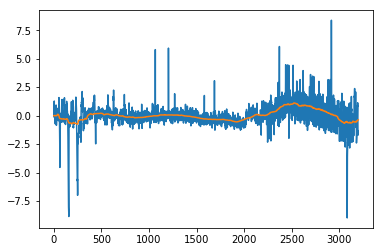

332


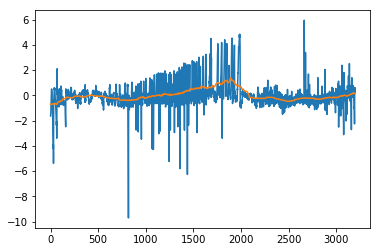

338


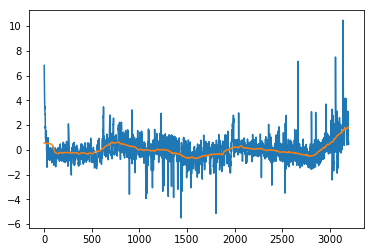

341


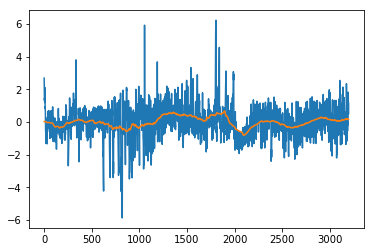

344


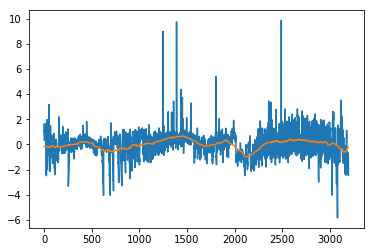

346


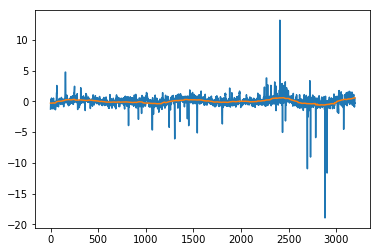

347


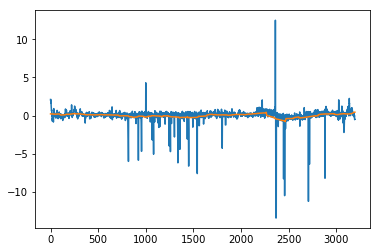

349


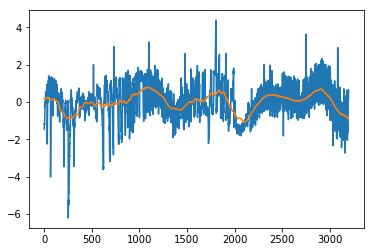

350


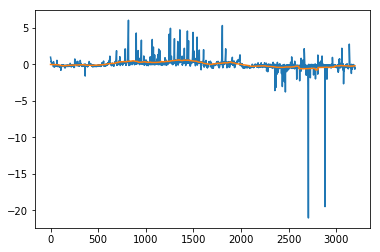

352


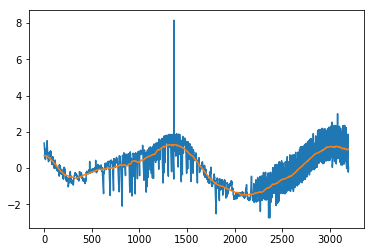

353


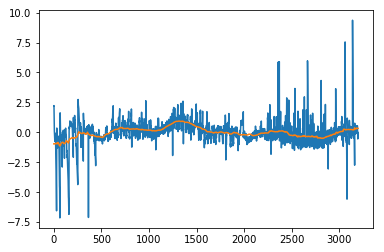

360


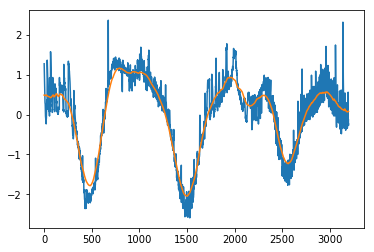

363


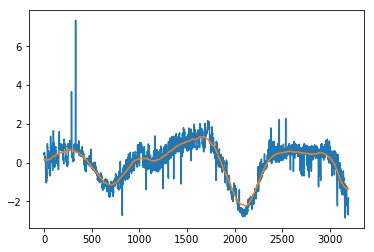

367


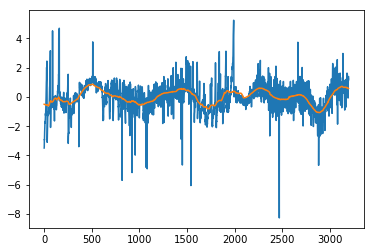

372


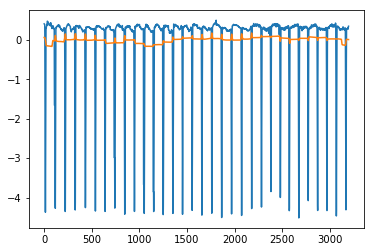

386


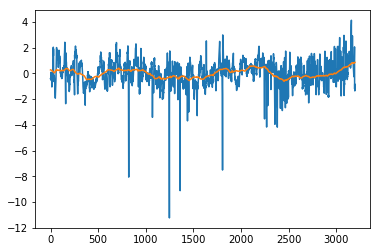

395


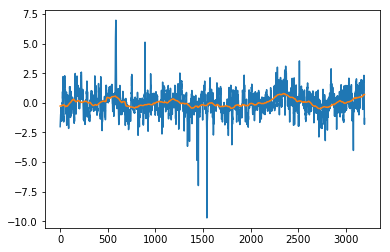

399


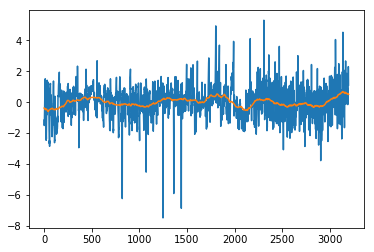

400


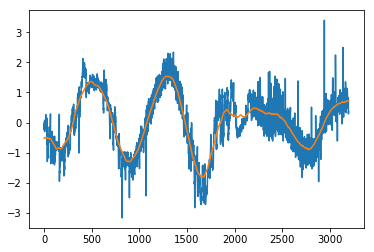

402


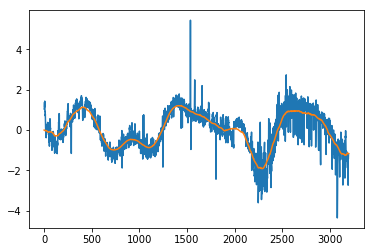

415


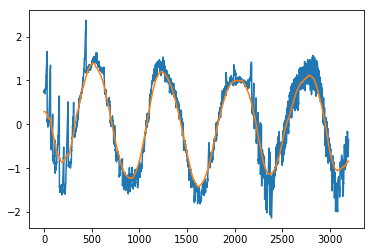

417


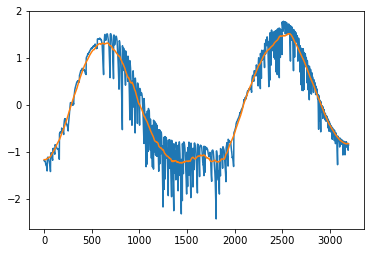

421


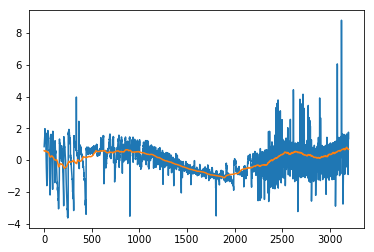

422


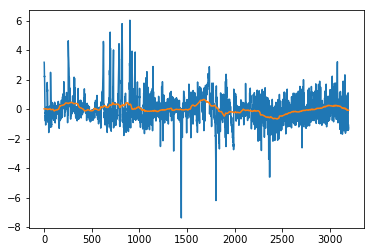

432


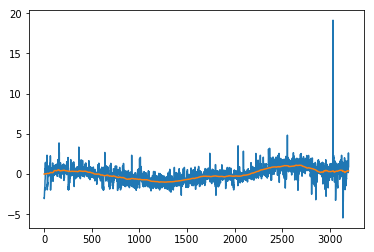

436


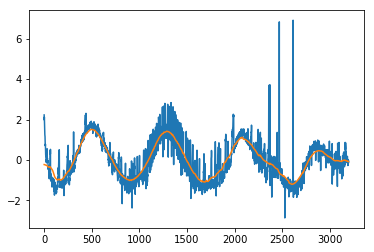

456


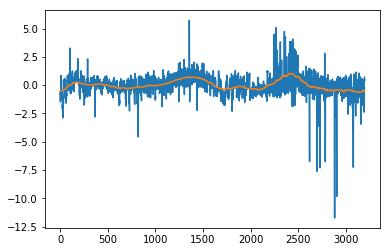

460


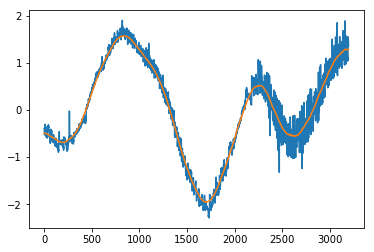

461


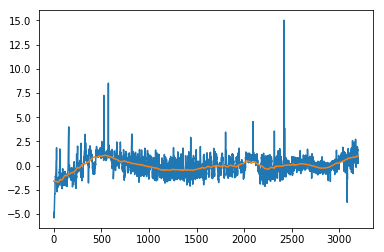

463


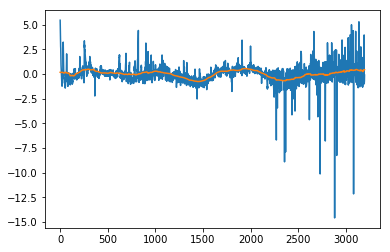

464


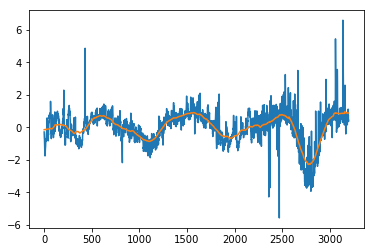

465


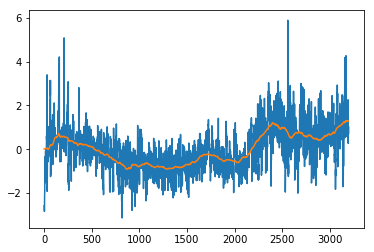

481


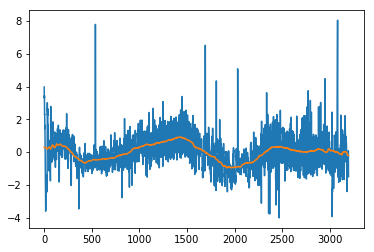

482


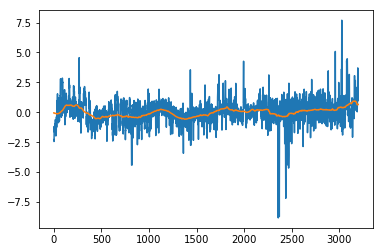

485


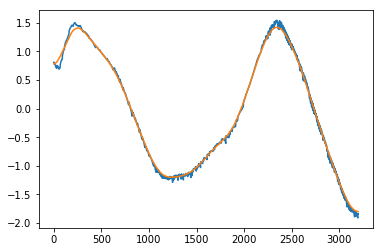

486


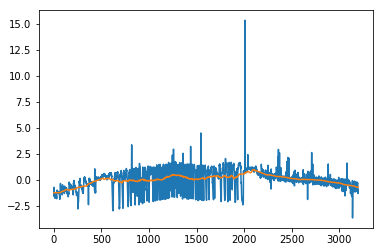

487


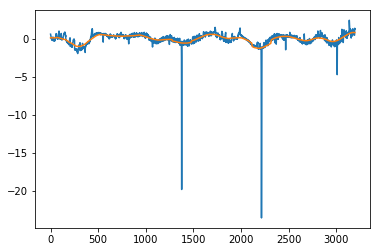

488


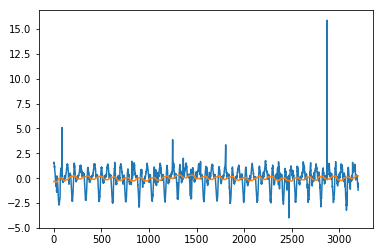

493


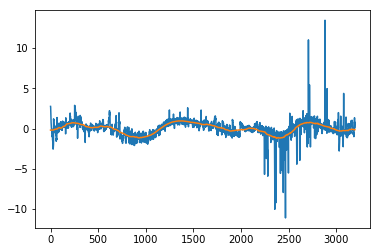

498


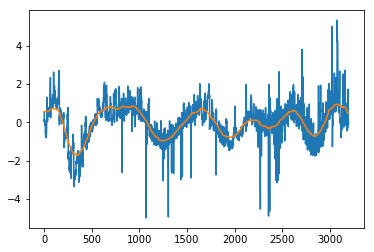

502


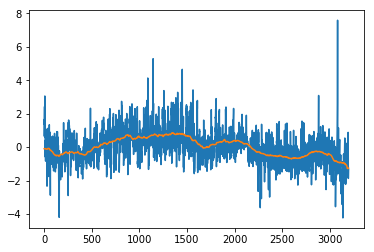

504


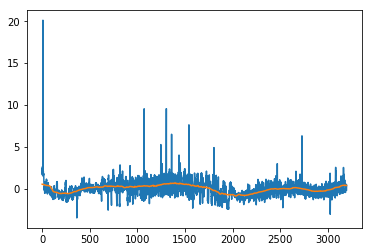

506


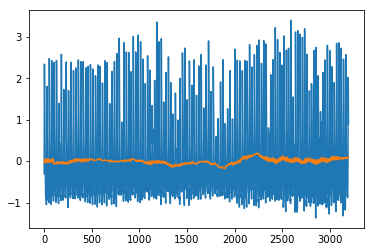

508


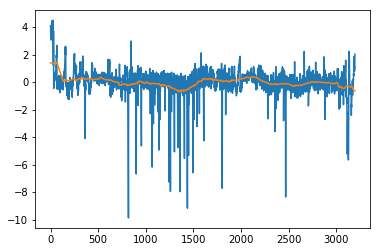

509


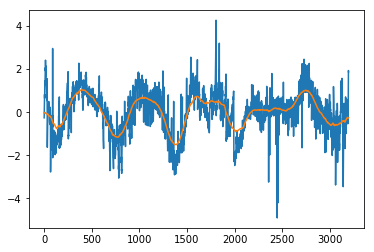

513


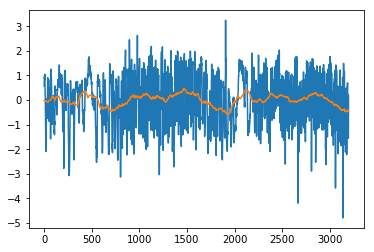

518


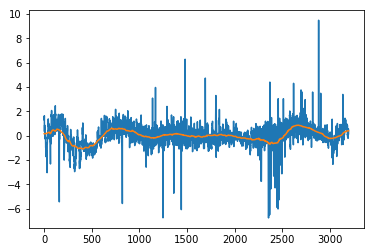

520


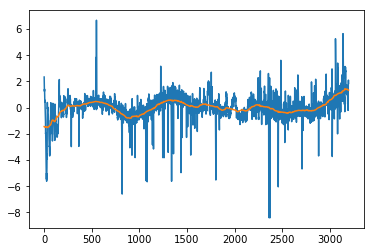

523


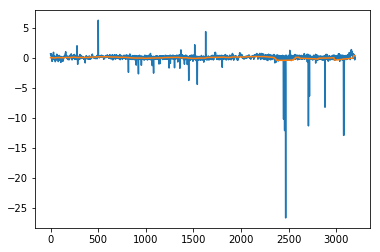

524


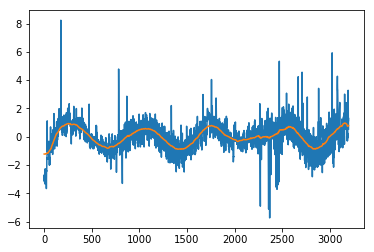

525


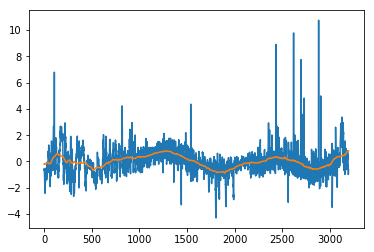

526


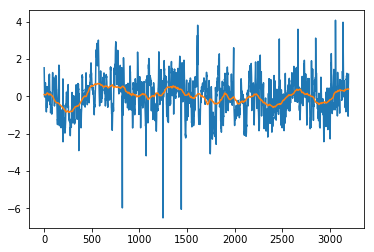

527


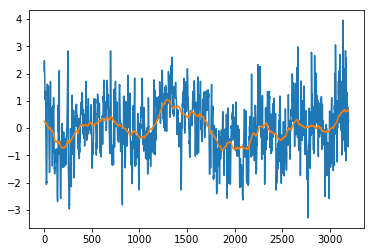

537


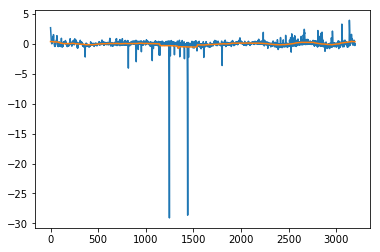

540


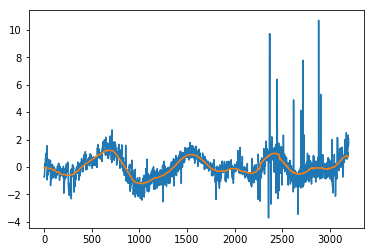

544


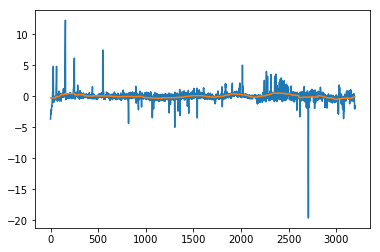

549


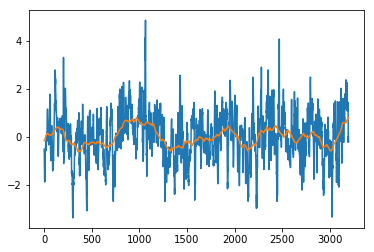

551


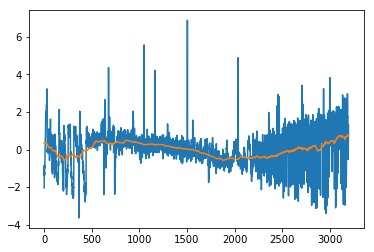

552


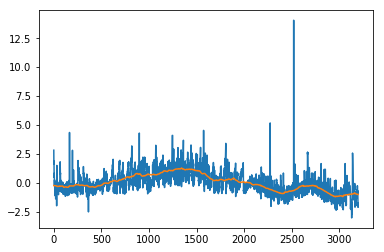

553


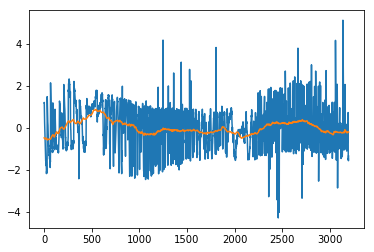

560


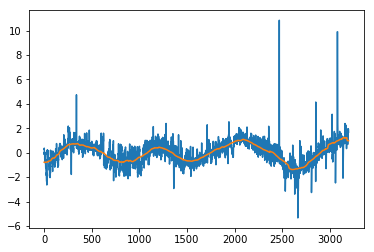

565


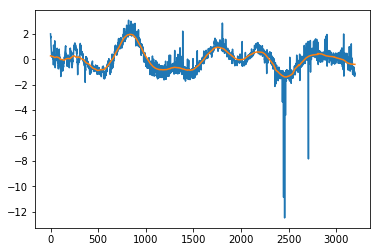

In [15]:
false_positives = np.where(y_hat * (1. - y_test) > 0.5)[0]
for i in non_idx:
    if y_hat[i] > crossover_cutoff:
        print(i)
        plt.plot(x_test[i])
        plt.show()

It seems NASA missed one planet. I take this opportunity to claim it, and hereby name it Kaggle alpha :)